In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Carregamento de bibliotecas

In [23]:
from sklearn.svm import SVC
from sklearn.utils import shuffle
from time import time as tick
import numpy as np
import imageio as iio
import math
from joblib import dump, load
from IPython.display import clear_output
import random
from sklearn.metrics import confusion_matrix 

### Programa

#### Carregamento de imagens de treino e de teste

In [3]:
dir_training = 'DRIVE/training/images/'
dir_test = 'DRIVE/test/images/'
dir_sol1_test = 'DRIVE/test/1st_manual/'
dir_sol2_test = 'DRIVE/test/2nd_manual/'
dir_mask_training = 'DRIVE/training/new_mask/'
dir_mask_test = 'DRIVE/test/new_mask/'
dir_sol_training = 'DRIVE/training/1st_manual/'

N = 20
training = []
sol_training = []
masks_training = []
test = []
sol1_test = []
sol2_test = []
mask_test = []

for i in range(N):
    
    #training images and masks
    training.append(255-iio.imread(dir_training + str(20+i+1)+'_training.tif')[:,:,1].astype(np.float64))
    #training.append(255-iio.imread(dir_training + str(20+i+1)+'_training.tif')[:,:,1])
    sol_training.append(iio.imread(dir_sol_training + str(20+i+1)+'_manual1.gif'))
    masks_training.append(iio.imread(dir_mask_training + str(20+i+1)+'_training_mask.gif'))
    
    #test images and masks
    if i<9:
        pre = '0'
    else:
        pre = ''
    test.append(255-iio.imread(dir_test + pre +str(i+1)+'_test.tif')[:,:,1].astype(np.float64))
    sol1_test.append(iio.imread(dir_sol1_test + pre  + str(i+1)+'_manual1.gif'))
    sol2_test.append(iio.imread(dir_sol2_test + pre  + str(i+1)+'_manual2.gif'))
    mask_test.append(iio.imread(dir_mask_test + pre +str(i+1)+'_test_mask.gif'))
    
    #plot some images to check
    #if i%5 ==0:
    #    plt.imshow(mask_test[i], cmap = 'gray')
    #    plt.figure()


# 1ª PARTE

#### Determinação dos parâmetros das imagens:  line strength, orthogonal line strength e intensidade (x = [S, So, I])

Função que determina as 12 retas cuja inclinação incrementa de 15 graus. Devolve uma matriz 12x15x2 com as coordenadas dos pontos da reta. Faz o mesmo para as respetivas 12 linhas ortogonais de 3 pontos devolvendo uma matriz 12x3x2.

In [4]:
def lines_opt(l = 15, c = 15, centerx = 7, centery = 7, deg_step = 15, n_steps = 12):
    #returns coordinates of the pixels in a 15x15 window correspondent to the lines calculated
    
    lines = np.zeros((l, c), int) 
    lines_plot = np.zeros((n_steps, l, c), int) 
    lines_coord = np.zeros((n_steps, l, 2), int)
    lines_ort_plot = np.zeros((n_steps, l, c), int) 
    lines_ort_coord = np.zeros((n_steps, 3, 2), int)
    
    for i in range(n_steps):
        for j in range(c):
            #evaluate value of funciton y = slope*x where x is the pixel count within the center pixel(0,0)
            j_ = j
            j_ort = j
            
            if deg_step*i<=45 or deg_step*i>=135:
                slope = tan(deg_step*i*math.pi/180.0)
                lines[i, j] = max(min(c-1-round(slope*(j-centerx) + centery), l-1), 0)  
                
            else:
                slope = tan(deg_step*i*math.pi/180.0 - math.pi/2.)
                lines[i,j] = j
                j_ = max(min(round(slope*(lines[i,j]-centerx) + centery), l-1), 0)
            
            lines_plot[i, lines[i, j], j_ ] = 1
            lines_coord[i,j,0] = lines[i, j]
            lines_coord[i,j,1] = j_
            
            
            
    lines_ort_coord[:, :, :] = np.roll(lines_coord[:, centerx-1:centerx+2, :],6,axis=0)
    for i in range(n_steps):
        lines_ort_plot[i][lines_ort_coord[i, :, 0], lines_ort_coord[i, :, 1]] = 1
    
    #print(lines_ort_coord)
    
    i = 0
    _, axs = plt.subplots(2,6,figsize=[12,4],constrained_layout=True)
    _, axs2 = plt.subplots(2,6,figsize=[12,4],constrained_layout=True)
    for il in range(2):
        for ic in range(6):
            axs[il, ic].imshow(lines_plot[i])
            axs[il, ic].set_title(str(i*deg_step) + ' degrees')
            
            axs2[il, ic].imshow(lines_ort_plot[i])
            axs2[il, ic].set_title(str(i*deg_step) + ' degrees')
            i = i + 1    
    
    return lines_coord, lines_ort_coord


C:\Users\magda\anaconda3\lib\site-packages\IPython\core\events.py:89: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  func(*args, **kwargs)


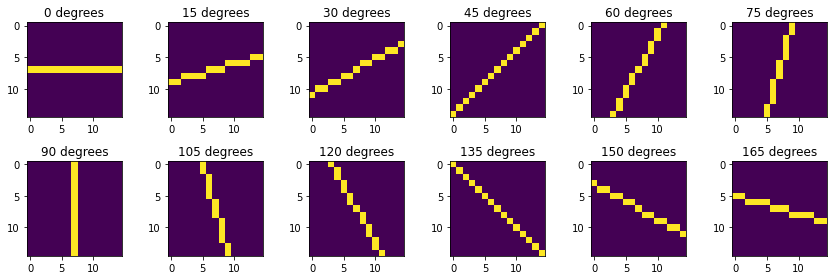

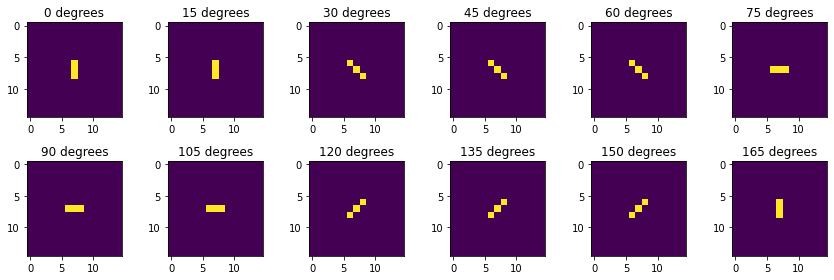

In [153]:
l, l_ort = lines_opt()
#print(l)

##### Verificação do formato e conteúdo das matrizes das linhas

In [6]:
print('Formato da matriz das 12 linhas: ', np.shape(l))
print('Formato da matriz das 12 linhas ortogonais: ', np.shape(l_ort))
print('Pontos da segunda linha (15 graus):')
print(l[1,:,:].transpose())
print('Pontos da segunda linha ortogonal (90+15 graus):')
print(l_ort[1,:,:].transpose())

Formato da matriz das 12 linhas:  (12, 15, 2)
Formato da matriz das 12 linhas ortogonais:  (12, 3, 2)
Pontos da segunda linha (15 graus):
[[ 9  9  8  8  8  8  7  7  7  6  6  6  6  5  5]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]]
Pontos da segunda linha ortogonal (90+15 graus):
[[6 7 8]
 [7 7 7]]


### Cálculo de parâmetros para uma imagem inteira

Função que determina os parâmetros para todos os pontos da imagem passada como argumento, mas somente dentro da retina com base na máscara respetiva que é também passada como argumento. Para o cálculo das features recorre então às coordenadas das linhas previamente calculadas e que seguem como argumento.

In [7]:
def parameters_opt(img_, mask_, sol_,lines, lines_ort):
    
    #constants
    n_lines = 12
    dim = 7
    NL, NC = np.shape(img_)
    print('Image dimensions: ', NL, NC)
    
    #index for the line with greatest intensity: needed for retrieval of correspondent orthogonal
    iline_main = 0
   
    #padding
    img = np.pad(img_, ((dim, dim), (dim, dim)))
    mask = np.pad(mask_, ((dim, dim), (dim, dim)))
    sol = np.pad(sol_, ((dim, dim), (dim, dim)))
    
    #features initialization: should be replaced by simple list, for now they even have the padding shape
    S_test = img.copy()
    I_test = img.copy()
    So_test = img.copy()
    Y_test = img.copy()
    S_test[:] = 0
    So_test[:] = 0
    I_test[:] = 0
    Y_test[:] = 0
        
    #loop trough all the pixels and calculate features
    for i in range(dim, NL+dim):
        for j in range(dim, NC+dim):
            
            #just calculate features for pixels within the retin
            if mask[i,j]!=0:
                
                #retrieve window around pixel for image and mask
                mask_window = mask[i - dim: i + dim + 1, j - dim: j + dim + 1]
                pixel_window = img[i - dim: i + dim + 1, j - dim: j + dim + 1]
                
                #treat border points: fill outside pixels with the remaining's average
                if mask_window[0,0]==0 or mask_window[14,14]==0 or mask_window[0,14]==0 or mask_window[14,0]==0:
                    pixel_window[mask_window == 0] = np.mean(pixel_window[mask_window != 0])
                
                #determine average intensity
                N_ = np.mean(pixel_window)
                
                #retrieve pixel intensity
                I_test[i,j] = img[i,j]
                
                #retrieve solution for that pixel
                Y_test[i,j] = sol[i,j]
                 
                #determine L: greatest intensity level across the lines
                L = np.mean(pixel_window[lines[0,:,0], lines[0,:,1]])
                for i_line in range(1, n_lines):
                    lines_int = pixel_window[lines[i_line,:,0], lines[i_line,:,1]].mean()
                    L_ = L
                    L = max(lines_int, L)
                    if L != L_:
                        iline_main = i_line
                
                #determine S
                S_test[i,j] = L - N_
                
                #retrieve intensity from respective orthogonal line
                Lo = np.mean(pixel_window[lines_ort[iline_main, :, 0], lines_ort[iline_main, :, 1]]) 
                
                #determine So
                So_test[i,j] = Lo - N_
                
    #normalize vector in order to not consider brightness variations
    S_test[mask != 0] = (S_test[mask != 0] - np.mean(S_test[mask != 0]))/np.std(S_test[mask != 0])
    So_test[mask != 0] = (So_test[mask != 0] - np.mean(So_test[mask != 0]))/np.std(So_test[mask != 0])
    I_test[mask != 0] = (I_test[mask != 0] - np.mean(I_test[mask != 0]))/np.std(I_test[mask != 0])
    
    print('Fim')
     
    return S_test, So_test, I_test, Y_test, mask

##### Teste da função que calcula as features para uma imagem inteira.

In [8]:
t1 = time.time()
S_test1_image, So_test1_image, I_test1_image, Y_test1_image, mask_test1_image = parameters_opt(training[0], masks_training[0], sol_training[0], l, l_ort)
t2 = time.time()
print(t2-t1)

Image dimensions:  584 565
Fim
65.44385504722595


##### Verificação do cálculo correto das features

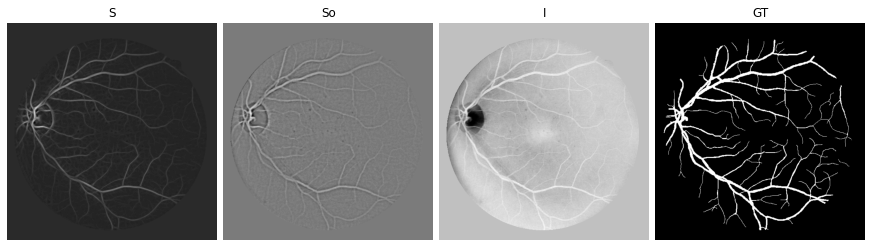

In [66]:
_, axs = plt.subplots(1,4,figsize=[12,12],constrained_layout=True)
axs[0].imshow(S_test1_image, cmap = 'gray')
axs[0].set_title('S')
axs[0].axis('off')
axs[1].imshow(So_test1_image, cmap = 'gray')
axs[1].set_title('So')
axs[1].axis('off')
axs[2].imshow(I_test1_image, cmap = 'gray')
axs[2].set_title('I')
axs[2].axis('off')
axs[3].imshow(Y_test1_image, cmap = 'gray')
axs[3].set_title('GT')
axs[3].axis('off')
plt.show()

##### Reformatação das features para o X e Y necessário

In [12]:
#retrieve only points that are not padding and go from matrix->array
dim = 7
S_test1_f = (S_test1_image[dim:-dim, dim:-dim]).flatten()
So_test1_f = (So_test1_image[dim:-dim, dim:-dim]).flatten()
I_test1_f = (I_test1_image[dim:-dim, dim:-dim]).flatten()
Y_test1_f = (Y_test1_image[dim:-dim, dim:-dim]).flatten()
mask_test1_f = (mask_test1_image[dim:-dim, dim:-dim]).flatten()

#instance....but why?
S_tes1_final = S_test1_f
So_tes1_final = So_test1_f
I_tes1_final = I_test1_f
Y_tes1_final = Y_test1_f
mask_tes1_final = mask_test1_f

#check for initial shapes
#print(np.shape(S_tes1_final), np.shape(So_tes1_final),np.shape(I_tes1_final),np.shape(Y_tes1_final))

#how many points should be used for testing: every point but the ones outside retin
length = np.shape(S_tes1_final)[0] - np.shape(I_test1_f[mask_tes1_final==0])[0]
#print(length)
#print('Pontos iniciais totais: ', np.shape(S_tes1_final)[0])
#print('Pontos removidos: ',np.shape(I_test1_f[mask_test1_f==0])[0])
#print('Pontos removidos em baixo: ',np.shape(I_tes1_final[mask_tes1_final==0])[0])
#print('Pontos aceites no final: ', np.shape(S_tes1_final[mask_tes1_final!=0])[0])

X_image = np.zeros((length, 3), float)
Y_image = np.zeros((length), float)

X_image[:,0] = S_tes1_final[mask_tes1_final!=0]
X_image[:,1] = So_tes1_final[mask_tes1_final!=0]
X_image[:,2] = I_tes1_final[mask_tes1_final!=0]
Y_image[:] = Y_tes1_final[mask_tes1_final!=0]

print('Verificacao do "formato" final\n')
print('Formato X: ', np.shape(X_image))
print(X_image)
print('Formato Y: ', np.shape(Y_image))
print(Y_image)

Verificacao do "formato" final

Formato X:  (220382, 3)
[[-0.70272494 -0.83586269 -0.70405292]
 [-0.68975737 -0.70395454 -0.53816863]
 [-0.81221067 -2.26158023 -0.75934768]
 ...
 [-0.45751146 -0.31487641  1.2312638 ]
 [-0.46314015 -0.20042615  1.28655857]
 [-0.29875892  0.05652197  1.50773762]]
Formato Y:  (220382,)
[0. 0. 0. ... 0. 0. 0.]


#####  Cálculo features para todas as imagens
Desta forma, os testes que se seguirão, nomeadamente, os de cross-validation resumir-se-ão à operação de sorteamento dos pontos com features já calculadas. Após o cálculo, as features são guardadas em disco.

Função que resume as operações de cálculo de features e de reformatação destas para X, Y.

In [7]:
def feature_format(img, mask, sol, l, l_ort, file_name):
    t1 = time.time()
    S_test1_image, So_test1_image, I_test1_image, Y_test1_image, mask_test1_image = parameters_opt(img, mask, sol, l, l_ort)
    t2 = time.time()
    print('Image ', str(i), 'took ',t2-t1, ' seconds.')
    
    #retrieve only points that are not padding and go from matrix->array
    dim = 7
    S_test1_f = (S_test1_image[dim:-dim, dim:-dim]).flatten()
    So_test1_f = (So_test1_image[dim:-dim, dim:-dim]).flatten()
    I_test1_f = (I_test1_image[dim:-dim, dim:-dim]).flatten()
    Y_test1_f = (Y_test1_image[dim:-dim, dim:-dim]).flatten()
    mask_test1_f = (mask_test1_image[dim:-dim, dim:-dim]).flatten()
    
    #instance....but why?
    S_tes1_final = S_test1_f
    So_tes1_final = So_test1_f
    I_tes1_final = I_test1_f
    Y_tes1_final = Y_test1_f
    mask_tes1_final = mask_test1_f
    
    #check for initial shapes
    print(np.shape(S_tes1_final), np.shape(So_tes1_final),np.shape(I_tes1_final),np.shape(Y_tes1_final))
    
    #how many points should be used for testing: every point but the ones outside retin
    length = np.shape(S_tes1_final)[0] - np.shape(I_test1_f[mask_tes1_final==0])[0]
    print(length)
    print('Pontos iniciais totais: ', np.shape(S_tes1_final)[0])
    print('Pontos removidos: ',np.shape(I_test1_f[mask_test1_f==0])[0])
    print('Pontos removidos em baixo: ',np.shape(I_tes1_final[mask_tes1_final==0])[0])
    print('Pontos aceites no final: ', np.shape(S_tes1_final[mask_tes1_final!=0])[0])
    
    X_image = np.zeros((length, 3), float)
    Y_image = np.zeros((length), float)
    
    X_image[:,0] = S_tes1_final[mask_tes1_final!=0]
    X_image[:,1] = So_tes1_final[mask_tes1_final!=0]
    X_image[:,2] = I_tes1_final[mask_tes1_final!=0]
    Y_image[:] = Y_tes1_final[mask_tes1_final!=0]
    
    
    X_filename = file_name + '_X'
    Y_filename = file_name + '_Y'
    dump(X_image,X_filename)
    dump(Y_image,Y_filename)
    
    print('Image ', str(i),' saved.')
    return 

In [ ]:
for i in range(20):
    
    clear_output(wait=True)
    #train
    file_name = 'Features/train_' + str(i)
    feature_format(training[i], masks_training[i], sol_training[i], l, l_ort, file_name)
    
    #test
    file_name = 'Features/test_' + str(i)
    feature_format(test[i], mask_test[i], sol1_test[i], l, l_ort, file_name)

### Cálculo de parâmetros para uma pontos aleatórios

Esta secção é dedicada a uma função de cálculo de features alternativa, que é em tudo semelhante à já apresentada (parameters_opt), mas que trata somente de um certo número de pontos requeridos para as imagens de treino e sorteados.

##### Função sorteadora de coordenadas
Recebendo a máscara que define quais os pontos fora da retina que não nos interessarão, sorteia um N conjunto de coordenadas obdecendo ao número de pontos disponíveis dados pelas dimensões da imagem NL, NC. Devolve então duas litas correspondentes às duas coordenadas dos N pontos sorteados. O algoritmo desta função foi, na verdade proposto pelo docente durante as aulas.

In [13]:
def random_pixels(mask, NL, NC, N):
    li, lj = [], []
    while True:
        i = randint(0, NL)
        j = randint(0, NC)
        
        if mask[i,j]>0:
            li.append(i)
            lj.append(j)
            if len(li)>N:
                break
    return li, lj

##### Função para o cálculo das features de pontos random

Função que determina as features dos N pontos aleatórios para treino da imagem passada como argumento, img_. À semelhança da que calculava para a imagem toda, recebe também a respetiva máscara, masl_, e solução, sol_. Além disso, as coordenadas associadas às linhas, lines e lines_ort.

In [14]:
def parameters_opt_random(img_, mask_, sol_, lines, lines_ort, N = 1000):
    
    #constants
    n_lines = 12
    dim = 7
    NL, NC = np.shape(img_)
    
    #index for the line with greatest intensity: needed for retrieval of correspondent orthogonal
    iline_main = 0

    #padding
    img = np.pad(img_, ((dim, dim), (dim, dim)))
    mask = np.pad(mask_, ((dim, dim), (dim, dim)))
    sol = np.pad(sol_, ((dim, dim), (dim, dim)))
    
    #features initialization
    S = []
    So = []
    I = []
    Y = []    
    
    #random picking of pixels 
    li, lj = random_pixels(mask, NL + dim*2, NC + dim*2, N)
    
    #counter for control of pixels done
    count = 0    
    
    #loop through all the N pixels
    for j in range(N):
        
            #retrieve window around pixel for image and mask
            mask_window = mask[li[j] - dim: li[j] + dim + 1, lj[j] - dim: lj[j] + dim + 1]
            pixel_window = img[li[j] - dim: li[j] + dim + 1, lj[j] - dim: lj[j] + dim + 1]
            
            #treat border points: fill outside pixels with the remaining's average
            if mask_window[0,0]==0 or mask_window[14,14]==0 or mask_window[0,14]==0 or mask_window[14,0]==0:
                pixel_window[mask_window == 0] = np.mean(pixel_window[mask_window != 0])
            
            #determine average intensity
            N_ = np.mean(pixel_window)
            
            #retrieve pixel intensity
            I.append(img[li[j],lj[j]])
            
            #retrieve pixel solution
            Y.append(sol[li[j],lj[j]])
             
            #determine L: greatest intensity level across the lines
            L = np.mean(pixel_window[lines[0,:,0], lines[0,:,1]])
            for i_line in range(1, n_lines):
                lines_int = pixel_window[lines[i_line,:,0], lines[i_line,:,1]]
                L_ = L
                L = max(np.mean(lines_int), L)
                if L != L_:
                    iline_main = i_line
            #determine S           
            S.append(L - N_)
            
            #retrieve intensity from respective orthogonal line
            Lo = np.mean(pixel_window[lines_ort[iline_main, :, 0], lines_ort[iline_main, :, 1]]) 
            
            #determine So
            So.append(Lo - N_)
            
            count = count + 1
                
    #normalize vector to not consider brightness variations
    S = (S - np.mean(S))/np.std(S)
    So = (So - np.mean(So))/np.std(So)
    I = (I - np.mean(I))/np.std(I)
    
    #print('Fim')
     
    return S, So, I, Y

##### Teste do cálculo das features de todos os 20k pontos de treino

In [15]:
n = 1000
X = np.zeros((N*n, 3), float)
Y = np.zeros((N*n), float)

for i in range(N):
    S_test, So_test, I_test, Y_test = parameters_opt_random(training[i], masks_training[i], sol_training[i], l, l_ort)
    X[i*n:(i+1)*n, 0] = S_test
    X[i*n:(i+1)*n, 1] = So_test
    X[i*n:(i+1)*n, 2] = I_test
    Y[i*n:(i+1)*n] = Y_test

### SVM
Nesta secção procede-se, efetivamente, ao treino do classificador e consequente avaliação. São, contudo, realizados apenas testes precoces, sem tunning de hiperparâmetros.

##### Criação do classificador

In [17]:
clf1 = SVC(kernel='rbf', gamma=0.05)

##### Treinar o classificador

In [21]:
t1 = time.time()
clf1 = clf1.fit(X, Y)
t2 = time.time()
print('Tempo de treino: ',t2-t1)

Tempo de treino:  6.39013671875


##### Previsão do resultado

In [22]:
t1 = time.time()
y_pred_train = clf1.predict(X_image)
t2 = time.time()
print('Tempo de previsão: ', t2-t1)

Tempo de previsão:  133.97527885437012


##### Cálculo taxa de sucesso

=======================  Métrica =========================
tn:  194315 fp:  fp:  1540 fn:  8763 tp:  15764
1 - Taxa de sucesso (imagem de treino):  95.32493579330435
2 - Taxa de sucesso (imagem de treino):  95.32493579330435


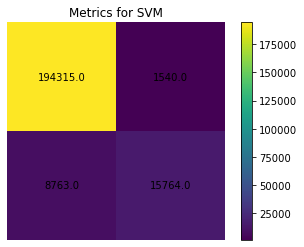

In [40]:
tn, fp, fn, tp = confusion_matrix(Y_image, y_pred_train).ravel()
print('=======================  Métrica =========================')
print('tn: ', tn, 'fp: ', 'fp: ', fp, 'fn: ', fn, 'tp: ', tp)
print('1 - Taxa de sucesso (imagem de treino): ', (tp+tn)/(tp+tn+fp+fn)*100)
print("2 - Taxa de sucesso (imagem de treino): ",
      np.mean(y_pred_train == Y_image) * 100)


c = np.zeros((2,2))
c[0,0], c[0,1], c[1,0], c[1,1] = tn, fp, fn, tp

plt.imshow(c)
plt.colorbar()
plt.axis('off')

for (j,i),label in np.ndenumerate(c):
    plt.text(i,j,label,ha='center',va='center')
plt.title('Metrics for SVM')
plt.show()

##### Verificação visual dos resultados

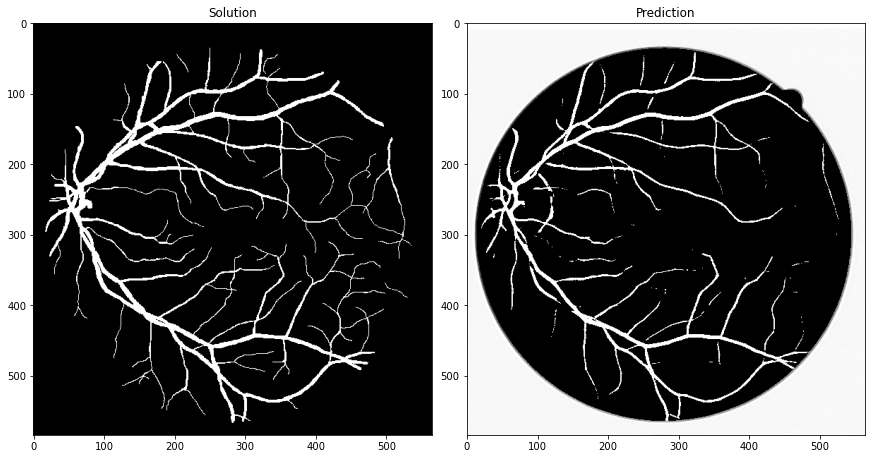

In [50]:
_, axs = plt.subplots(1,2,figsize=[12,12],constrained_layout=True)
axs[0].imshow(sol_training[0],cmap = 'gray')
axs[0].set_title('Solution')

img_copy = training[0].copy()
img_copy[masks_training[0]>0] =y_pred_train 
axs[1].imshow(img_copy,cmap = 'gray')
axs[1].set_title('Prediction')
plt.show()

# 2ª PARTE

### Cross-validation
Nesta secção começou-se por tornar a criação e treino de classificadores expedita de forma a poder formar os batches e fazer a sua rotação, experimentando diferentes hiperparâmetros gamma e c, com o objetivo de determinar o par de valores para os quais se obtém a melhor acc, realizando assim a validação cruzada.

Primeiramente, e como esta etapa foi já realizada numa fase posterior à determinação das features para imagens de treino e teste, faz-se o seu carregamento.

In [51]:
file_name_ftrain = 'Features/train_'
file_name_ftrain = 'Features/train_'
file_name_ftest = 'Features/test_'
file_name_stest = 'Features/test_'


features_train = load('Features/train_0_X')
solutions_train = load('Features/train_0_Y')
features_test = load('Features/test_0_X')
solutions_test = load('Features/test_0_Y')

dimensions_train = [np.shape(features_train)[0]]
dimensions_test = [np.shape(features_test)[0]]

N = 20

for i in range(1,N):
    file_name_ftrain_i = file_name_ftrain + str(i) + '_X'
    file_name_strain_i = file_name_ftrain + str(i) + '_Y'
    T = load(file_name_ftrain_i)
    S = load(file_name_strain_i)
    features_train = np.concatenate((features_train, T), axis = 0)
    solutions_train = np.concatenate((solutions_train, S), axis = 0)
    dimensions_train.append((np.shape(T))[0])
    
    file_name_ftest_i = file_name_ftest + str(i) + '_X'
    file_name_stest_i = file_name_ftest + str(i) + '_Y'
    T = load(file_name_ftest_i)
    S = load(file_name_stest_i)    
    features_test = np.concatenate((features_test, T), axis = 0)
    solutions_test = np.concatenate((solutions_test, S), axis = 0)
    dimensions_test.append((np.shape(T))[0])

Em segundo lugar, faz-se o sorteio dos 20000 pontos que serão divididos por 5 batches. Features de uma mesma imagem não deverão estar em batches diferentes. Então, sendo 1000 pontos tirados de cada imagem, em cada batch estarão features de 4 imagens.

Esta célula pode não ser processada no caso de já se ter feito run da célula idêntica mais acima. A razão da sua repetição está simplesmente no facto da corss-validation ter sido realizada numa fase posterior do projeto, sendo, portanto, conveniente apresentar o sorteamento dos pontos nesta secção do programa. Poder-se-ia argumentar, também, que em vez de executar uma célula idêntica, dado já se terem as features carregadas se poder proceder ao sorteamento dessas. Contudo, dada a rapidez em calcular as features de 20k pontos, manteve-se a mesma célula, dado não apresentar um inconveniente e permitir a reutilização de código já desenvolvido.

In [156]:
N = 20
n = 1000
X = np.zeros((N*n, 3), float)
Y = np.zeros((N*n), float)

for i in range(N):
    S_test, So_test, I_test, Y_test = parameters_opt_random(training[i], masks_training[i], sol_training[i], l, l_ort)
    X[i*n:(i+1)*n, 0] = S_test
    X[i*n:(i+1)*n, 1] = So_test
    X[i*n:(i+1)*n, 2] = I_test
    Y[i*n:(i+1)*n] = Y_test

Utilizar-se-ão 5 batches de features: 4 para treino do classificador e 1 para validação do mesmo. Enquanto que nas 4 primeiras se encontram 4k pontos (1k de cada uma das 4 imagens que constitui o grupo), na 5ª procura-se ter mais estatística para a validação. Esta exigirá, portanto, uma construção diferente e não poderá originar somente dos 20k pontos antes sorteados. Por facilidade mantém-se os 20k anteriores para treino e constrói-se aqui um novo set só para validação, já devidamente dividido em 5 batches compostas por 5k pontos de cada uma das 4 imagens que constituirão o batch. Perfaz-se, assim, um total de 20k pontos para a validação. 

Mais precisamente, a execução da célula resulta na construção de uma lista que terá os índices dos pontos a serem usados para validação em cada imagem, estando as features dos pontos já carregadas.

In [157]:
indexes = []
image_counter = 0
set_counter = 0

for i in range(5):
    for j in range(4):
        l = list(random.sample(range(dimensions_train[image_counter]), 5000))
        l = [x+np.sum(dimensions_train[:image_counter]) for x in l]
        
        
        if j == 0:
            indexes.append([])
            indexes[set_counter] = l
        else:
            indexes[set_counter] += l
        image_counter += 1
    set_counter += 1    

for i in range(5):
    indexes[i] = [int(x) for x in indexes[i]]
    
print('Formato da lista de indices de pontos para validação: ', np.shape(indexes))

Formato da lista de indices de pontos para validação:  (5, 20000)


##### Função para treino, previsão e cálculo da taxa de sucesso
Esta função sumariza os passos tomados para treino e avaliação de um classificador já encontrados antes. A sua utilidade surge com a cross-validation em que será exigida a criação, treino e previsão por parte de um classificador para diferentes pares de hiperparâmetros, tornando-se essencial que este processo possa ser chamado, por exemplo, num simples siclo for que itera sobre uma lista predefinida de hiperparâmetros que se deseje experimentar.

In [56]:
def train_validate(t, t_sol, v, v_sol, g, c):
    
    clf1 = SVC(kernel='rbf', C = c, gamma = g)
    clf1 = clf1.fit(t, t_sol)
    
    y_pred_train = clf1.predict(v)
    acc = np.mean(y_pred_train == v_sol) * 100
    
    return acc 

##### Função que realiza as 5 rotações de batches por par gamma/c
Na cross-validation por batches procura-se realizar rotações entre os 'papéis' das batches para os valores de gamma e c a serem experimentados. Isto é, cada uma das batches deverá ter a função de grupo de validação uma vez, enquanto que as 4 sobrantes servirão de treino nessa rotação.

In [69]:
def pair_5rotations(gamma, c, X, Y, Xval, Yval, ind_val):
    
    acc_average = 0.
    accs = []
    ind = [0, int(20000/5), int(20000/5*2),int(20000/5*3),int(20000/5*4),int(20000/5*5)]
    
    for i in range(5):
        print('\nRotação ' + str(i+1))
        acc_i = train_validate(X[ind[0]:ind[4]], Y[ind[0]:ind[4]], Xval[ind_val[4-i]], Yval[ind_val[4-i]], gamma, c)
        print('acc: ', acc_i)
        accs.append(acc_i)
        acc_average += acc_i
        X = np.roll(X, 4000, axis = 0)
        Y = np.roll(Y, 4000, axis = 0)
    
    acc_average /= 5.
    accs = [abs(x-acc_average) for x in accs]
    
    print('\n\nMédia acc: ', acc_average, ' +/- ', np.max(accs))
    return (acc_average)

Teste da função pair_rotations: 5 treinos e validações para um valor de c e gamma.

In [70]:
t1 = time.time()
acc = pair_5rotations(0.5, 0.6, X, Y, features_train, solutions_train, indexes)
t2 = time.time()
print("Tempo dispendido: ", t2-t1)


Rotação 1
acc:  94.64

Rotação 2
acc:  92.245

Rotação 3
acc:  94.77499999999999

Rotação 4
acc:  93.29499999999999

Rotação 5
acc:  93.595


 Média acc:  93.71  +/-  1.4649999999999892
Tempo dispendido:  62.566534996032715


##### Função sweeping dos hiperparâmetros
Esta função - hyperparameter_sweep - dado um range dos hiperparâmetros, percorre esse range e vai fazer a cross-validation para cada um dos valores sobre os quais itera para gamma e c. É também apresentada uma função que permite a visualização da acc média obtida para cada par gamma/c - imshow_pretty.

In [108]:
def imshow_pretty(grid, xs, ys, nx, ny):
    
    x = [ '%.2f' % elem for elem in xs ]
    y = [ '%.2f' % elem for elem in ys ]

    plt.rcParams["figure.figsize"] = [7.00, 3.50]
    plt.rcParams["figure.autolayout"] = True
    ax = plt.gca()
    ax.imshow(grid, extent=[0,1,0,1])
    ax.set_xlabel('c')
    ax.set_ylabel('gamma')
    ax.set_xticks(np.linspace(0,1,nx))
    ax.set_yticks(np.linspace(0,1,ny))
    ax.set_xticklabels(x)
    ax.set_yticklabels(np.flip(y))
    ax.set_title('Acc results for cross-validation')
    plt.show()
    
    return

In [76]:
def hyperparameter_sweep(gamma_range, c_range, X, Y, Xval, Yval, ind_val, n):
    
    gamma = np.linspace(gamma_range[0], gamma_range[1], n)
    c = np.linspace(c_range[0], c_range[1], n)
    
    acc_grid = np.zeros((n,n), float)
    i = -1
    
    gammas = []
    cs = []
    accs = []
    
    contador = 1
    
    for gamma_i in gamma:
        i += 1
        j = -1
        #gamma_i = 0.05
        for c_i in c:
            print('Par #' + str(contador))
            #c_i = 1
            j += 1
            acc_grid[i, j] = pair_5rotations(gamma_i, c_i, X, Y, Xval, Yval, ind_val)
            print('gamma ', gamma_i, 'c ', c_i, ': ', acc_grid[i, j])
            gammas.append(gamma_i)
            cs.append(c_i)
            accs.append(acc_grid[i,j])
            clear_output(wait=True)    
            
            contador += 1
            
            
    imshow_pretty(acc_grid, c, gamma, n, n)
    return gamma, c, acc_grid

Simples teste - 4 pares gamma/c

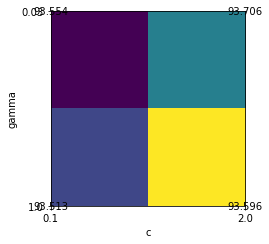

In [90]:
gammas, cs, acc_grid = hyperparameter_sweep([0.03,1], [0.1,2.0], X, Y, features_train, solutions_train, indexes, 2)

Verdadeira tentativa de encontrar o melhor par de hiperparâmetros, testando um total de 100 combinações gamma/c.

In [ ]:
gammas2, cs2, acc_grid2 = hyperparameter_sweep([0.01,2.0], [0.01,2.0], X, Y, features_train, solutions_train, indexes, 10)

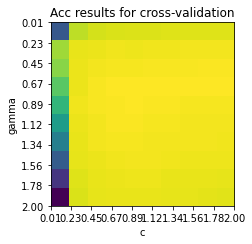

In [111]:
imshow_pretty(acc_grid2, cs2, gammas2, 10, 10)

Olhando em mais detalhe para a região de maior acc:

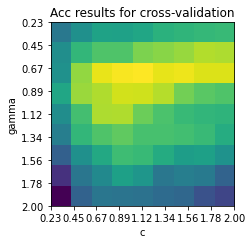

In [110]:
imshow_pretty(acc_grid2[1:,1:], cs2[1:], gammas2[1:], 9, 9)

Tira-se o melhor resultado com o respetivo par gamma/c:

In [128]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [135]:
max_acc = np.max(acc_grid2)
ind = unravel_index(acc_grid2.argmax(), acc_grid2.shape)
gamma_max = gammas2[ind[0]]
c_max = cs2[ind[1]]
print('Melhor acc de ', max_acc, ' encontrada para gamma = ', gamma_max, 'e c = ', c_max)

Melhor acc de  93.758  encontrada para gamma =  0.6733333333333333 e c =  1.1155555555555556


### Otimização por evolução da variação

Com o algoritmo que se segue é feita a tentativa de se otimizar se forma mais rigorosa a expedita o tunning dos hiperparâmetros. Isto é realizado recorrendo às derivadas parciais da accuracy relativamente a c e a gamma. Face ao sweeping dos hiperparâmetros, é esperado um hiperplano que terá um máximo para um certo par de c e gamma. É elaborado um algoritmo iterativo que avalia a evolução da accuracy de acordo à variação dos hiperparâmetros, tentanto a evolução no sentido certo tendo em conta pontos do hiperplano previamente calculados.

Com base no melhor resultado do hyperparamenter sweep, realizado previamente, inicia-se a função de otimização nesse ponto e tendo em conta os pontos vizinhos que permitem saber a tendência para cada um dos lados.

Avançando com um step previamente definido, verfica-se a nova acc obtida por validação cruzada. Se diminui, volta-se ao ponto anterior e progride-se no mesmo sentido mas com um step inferior. Se aumentou, avalia-se novamente os pontos vizinhos avaliando para que lado poderia estar um novo melhor resultado. 

Tem-se primeiro uma função simples que calcula as derivadas parciais num certo ponto, dado os 4 vizinhos - gradient. E a função que tentará realizar a optimização procurando pelo par gamma/c que fará o modelo com a melhor acc - hyperparameter_optimization.

In [136]:
def gradient(x_lower, x_higher, y_lower, y_higher):
    
    num = y_higher - y_lower
    den = x_higher - x_lower
    
    grad = num/den
    
    return grad

In [168]:
def hyperparameter_optimization(gammas, cs, accs, ind_gamma0, ind_c0, X, Y, Xval, Yval, ind_val, max_iter):
    
    #current values with maximum accuracy
    acc_cur = 0.
    gamma_cur = gammas[ind_gamma0]
    c_cur = cs[ind_c0]
    
    
    #hyperparameters to be used in present iteration: starts with initial prediction from hyperparameter sweep
    gamma = gammas[ind_gamma0]
    c = cs[ind_c0]
    
    #steps for increasing/decreasing c and gamma according to their influence on the previous iteration
    c_step0 = 0.05
    gamma_step0 = 0.05
    
    #current steps
    c_step = c_step0
    gamma_step = gamma_step0
    
    #scales for the steps in accordance with gradient evolution: for small gradients, we must be near the maximum->reduce step
    gamma_scale = 0.5
    c_scale = 0.5
     
    #gradient calculation: neighbour points for gamma and c partial derivatives calculation
    gamma_lower = [gammas[ind_gamma0 - 1], accs[ind_gamma0 - 1, ind_c0]]
    gamma_higher = [gammas[ind_gamma0 + 1], accs[ind_gamma0 + 1, ind_c0]]
    c_lower = [cs[ind_c0 - 1], accs[ind_gamma0, ind_c0 - 1]]
    c_higher = [cs[ind_c0 + 1], accs[ind_gamma0, ind_c0 + 1]]
    
    #save values evolution
    gammas2 = []
    cs2 = []
    accs2 = []
    
    
    for i in range(max_iter):
        
        print('\nPar #', i+1, '-----> gamma: ', gamma, ' c: ', c)
        
        #cross validation for this pair of gamma/c
        acc_i = pair_5rotations(gamma, c, X, Y, Xval, Yval, ind_val) 
        
        #save current iteration
        accs2.append(acc_i)
        gammas2.append(gamma)
        cs2.append(c)
                    
        print('accuracy: ', acc_i)
                    
        #compare results
        if acc_cur < acc_i:#better result
                    
            #update neighbours: if previous step was positive, the value to be replaced is the lowest limit closest to the new value
            if gamma_step > 0:
                gamma_lower = [gamma_cur, acc_cur]
            else: 
                gamma_higher = [gamma_cur, acc_cur]
                    
            if c_step > 0:
                c_lower = [c_cur, acc_cur]
            else: 
                c_higher = [c_cur, acc_cur]
                    
            acc_cur = acc_i
            gamma_cur = gamma
            c_cur = c
            
                    
            
            
        else:      
            #update neighbours
            if gamma_step > 0:
                gamma_higher = [gamma, acc_i]
            else: 
                gamma_lower = [gamma, acc_i]
                    
            if c_step > 0:
                c_higher = [c, acc_i]
            else: 
                c_lower = [c, acc_i]
            
            
        #access by the gradient to each side one should vary gamma and c
        if gamma_lower[0] != gamma_higher[0]:
            grad_gamma = gradient(gamma_lower[0], gamma_higher[0], gamma_lower[1], gamma_higher[1])
        if c_lower[0] != c_higher[0]: 
            grad_c = gradient(c_lower[0], c_higher[0], c_lower[1], c_higher[1])
        
        if i != 0:
            #save gradients for next iteration
            delta_grad_gamma = abs(previous_grad_gamma - grad_gamma)
            delta_grad_c = abs(previous_grad_c - grad_c)
            
            #decrease step: but was there a hyperparameter, gamma or c, that conducted the evolution worse? Will be evaluated by which gradient increased the most
            if c_step > gamma_step:
                c_step *= c_scale
            else:
                gamma_step *= gamma_scale   
        
        previous_grad_gamma = grad_gamma
        previous_grad_c = grad_c
                    
        #update evolution direction according to new gradient 
        if grad_gamma != 0:
            gamma_step *= grad_gamma/abs(grad_gamma)
        if grad_c != 0:
            c_step *= grad_c/abs(grad_c)
        
        #update to new attempt of hyperparameters
        gamma = gamma_cur + gamma_step
        c = c_cur + c_step
        
    return accs2, gammas2, cs2

Teste da função de otimização por derivadas:

In [170]:
accs_opt1, gammas_opt1, cs_opt1 = hyperparameter_optimization(gammas2, cs2, acc_grid2, 3, 5, X, Y, features_train, solutions_train, indexes, 10)


Par # 1 -----> gamma:  0.6733333333333333  c:  1.1155555555555556

Rotação 1
acc:  94.41000000000001

Rotação 2
acc:  93.155

Rotação 3
acc:  94.8

Rotação 4
acc:  93.32000000000001

Rotação 5
acc:  93.61


 Média acc:  93.85900000000001  +/-  0.9409999999999883
accuracy:  93.85900000000001

Par # 2 -----> gamma:  0.7233333333333334  c:  1.1655555555555557

Rotação 1
acc:  94.44500000000001

Rotação 2
acc:  93.155

Rotação 3
acc:  94.8

Rotação 4
acc:  93.32000000000001

Rotação 5
acc:  93.575


 Média acc:  93.85900000000001  +/-  0.9409999999999883
accuracy:  93.85900000000001

Par # 3 -----> gamma:  0.6983333333333334  c:  1.1655555555555557

Rotação 1
acc:  94.44500000000001

Rotação 2
acc:  93.16499999999999

Rotação 3
acc:  94.815

Rotação 4
acc:  93.325

Rotação 5
acc:  93.58


 Média acc:  93.866  +/-  0.9489999999999981
accuracy:  93.866

Par # 4 -----> gamma:  0.7233333333333334  c:  1.1905555555555556

Rotação 1
acc:  94.45

Rotação 2
acc:  93.16

Rotação 3
acc:  94.795

Ro

Evolução da otimização

Text(0, 0.5, 'acc \\(%\\)')

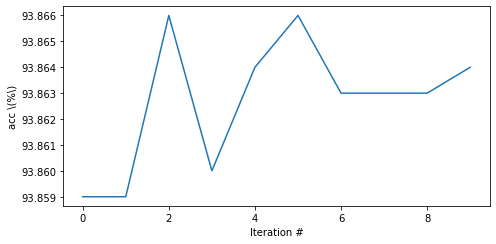

In [184]:
plt.plot(accs_opt1)
plt.xlabel('Iteration #')
plt.ylabel('acc \(%\)')
plt.show()

Recuperação do valor máximo de acc e respetivos gamma/c

In [175]:
max_acc_opt1 = np.max(accs_opt1)
ind = accs_opt1.index(max_acc_opt1)
gamma_max_opt1 = gammas_opt1[ind]
c_max_opt1 = cs_opt1[ind]
print('Melhor acc de ', max_acc_opt1, ' encontrada para gamma = ', gamma_max_opt1, 'e c = ', c_max_opt1)

Melhor acc de  93.866  encontrada para gamma =  0.6983333333333334 e c =  1.1655555555555557


### Otimização por Optuna

Optuna é uma livraria que apresenta métodos de otimização e de tunning de parâmetros de funções ditas funções "objetivo". Neste caso, a faunção objetivo é a função "pair_5rotations" com hiperparâmetros gamma e c. 

Pssando como argumento a dita função objetivo a tentativa será feita de minimizar o seu resultado por alteração iterativa dos hiperparâmetros da função objetivo. No caso presente, o objetivo deveria ser maximizar a acc por alteração do gamma e do c, pelo que se transofmra de uma forma simples a acc num resultado que se quser ver minimizado: -1*acc.

Utiliza-se esta função para poder determinar se os pontos encontrados por sweeping e por otimização baseada em gradientes foi capaz de efetivamente encontrar o par de hiperparâmetros que devolve a melhor acc, tendo, assim, uma segunda via de confirmação dos valores utilizados.

In [178]:
import optuna

hour = 3600
TRIALS = 10
TIMEOUT = hour*0.3

def objective(trial, X, Y, Xval, Yval, ind_val, c_min, c_max, gamma_min, gamma_max):
    
    global BEST_RESULT
    global HISTORY
    global BEST_MODEL
    
    gamma = trial.suggest_float("gamma", gamma_min, gamma_max)
    c = trial.suggest_float("c", c_min, c_max)
    acc = -1*pair_5rotations(gamma, c, X, Y, Xval, Yval, ind_val)
    
    clear_output(wait=True)
    
    HISTORY.append([gamma, c, acc])
    
    if acc < BEST_RESULT:
        BEST_RESULT = acc
        BEST_MODEL = (gamma, c)
    
    return acc

BEST_RESULT = np.inf
HISTORY = []
BEST_MODEL = None

study = optuna.create_study(
    sampler = optuna.samplers.TPESampler(multivariate = True),
    pruner = optuna.pruners.MedianPruner(n_warmup_steps = 2),
)

C:\Users\magda\anaconda3\lib\site-packages\optuna\samplers\_tpe\sampler.py:263: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2022-06-19 09:14:06,342] A new study created in memory with name: no-name-d0d4793d-bc39-4fe6-a582-cf99d8121ba7


- Teste 1 com Optuna - c in [0.01-2-0] e gamma in [0.01-2.0]

In [179]:
study.optimize(lambda trial: objective(trial, X, Y, features_train, solutions_train, indexes, 0.01, 2.0, 0.01, 2.0), TRIALS, TIMEOUT, show_progress_bar = True)

[I 2022-06-19 09:25:29,284] Trial 9 finished with value: -93.837 and parameters: {'gamma': 1.9957569952203966, 'c': 1.4159100165407281}. Best is trial 6 with value: -93.898.


Evolução da optimização por optuna e respetivo valor máximo obtido e respetivos hiperparâmetros.

In [187]:
max_acc_opt_optuna1 = -1*BEST_RESULT
gamma_max_opt_optuna1 = BEST_MODEL[0]
c_max__opt_optuna1 = BEST_MODEL[1]
print('Melhor acc de ', max_acc_opt_optuna1, ' encontrada para gamma = ', gamma_max_opt_optuna1, 'e c = ', c_max__opt_optuna1)

Melhor acc de  93.898  encontrada para gamma =  1.2598900109031865 e c =  1.038822080579744


# 3ª PARTE

### Resultados finais

Utilizando os hiperparâmetros que ofereceram melhor acc, realiza-se o treino final do classificador e consequente predict para todas as imagens, de treino e de teste.

É calculada a acc média final para o conjunto de imagens de treino e de teste e são guardadas em memória as previsões, assim como os mapas de probabilidade. Estes resultados são apresentados na totalidade no notebook destinado aos resultados 'Projeto SVM - resultados'. Apresenta-se aqui somente o resultado de uma imagem de treino e de teste em comparação com o GT.

##### Decisão da melhor acc e melhores hiperparâmetros entre as duas otimizações (gradiente e optuna) e o sweeping

In [199]:
acc_max_final = max(max_acc, max_acc_opt1, max_acc_opt_optuna1)


if acc_max_final == max_acc:
    print('Resultado do sweeping é o melhor')
    c_max_final = c_max
    gamma_max_final = gamma_max
elif acc_max_final == max_acc_opt1:
    print('Resultado da otimização por gradiente é o melhor')
    c_max_final = c_max_opt1
    gamma_max_final = gamma_max_opt1
elif acc_max_final == max_acc_opt_optuna1:
    print('Resultado da otimização por optuna é o melhor')
    c_max_final = c_max__opt_optuna1
    gamma_max_final = gamma_max_opt_optuna1

print('acc max: ', acc_max_final, ' gamma_final = ', gamma_max_final, 'c_final', c_max_final)

Resultado da otimização por optuna é o melhor
acc max:  93.898  gamma_final =  1.2598900109031865 c_final 1.038822080579744


##### Treino com os 20k pontos

In [201]:
clf1 = SVC(kernel='rbf', C = c_max_final, gamma = gamma_max_final)
clf1 = clf1.fit(X, Y)

##### Previsão
- Imagens de treino

In [ ]:
acc_train = []

for i in range(N):
    print('Imagem de treino ' + str(i))
    
    a = int(np.sum(dimensions_train[:i-1])*int(i!=0))
    b = int(np.sum(dimensions_train[:i+1]))+1
    
    y_pred_train = clf1.predict(features_train[a:b])
    acc_train.append(np.mean(y_pred_train == solutions_train[a:b]) * 100)
    print('Taxa de sucesso: ', acc_train[i])    
    dump(y_pred_train, 'Results/' + 'predict_train_' + str(i) + '_Y')
    
print('Average acc: ', np.mean(acc_train), ' +/- ', np.std(acc_train))

Imagem de treino 0
Taxa de sucesso:  95.4792338792012
Imagem de treino 1
Taxa de sucesso:  94.81055075407873
Imagem de treino 2


- Imagens de teste

In [16]:
acc_test = []

for i in range(N):
    print('Imagem de teste ' + str(i))
    
    a = int(np.sum(dimensions_test[:i-1])*int(i!=0))
    b = int(np.sum(dimensions_test[:i+1]))+1
    
    print(a)
    print(b)
    print(a-b)
    
    y_pred_test = clf1.predict(features_test[a:b])
    acc_test.append(np.mean(y_pred_test == solutions_test[a:b]) * 100)
    print('Taxa de sucesso: ', acc_test[i])    
    dump(y_pred_test, 'Results/' + 'predict_test_' + str(i) + '_Y')
    
print('Average acc: ', np.mean(acc_test), ' +/- ', np.std(acc_test))

Imagem de teste 0
0
220501
-220501
Taxa de sucesso:  94.6852848739915
Imagem de teste 1
0
441145
-441145
Taxa de sucesso:  94.47415248954425
Imagem de teste 2
220500
662334
-441834
Taxa de sucesso:  93.8187192475002
Imagem de teste 3
441144
882477
-441333
Taxa de sucesso:  93.46615820706813
Imagem de teste 4
662333
1103007
-440674
Taxa de sucesso:  93.75955922064837
Imagem de teste 5
882476
1323646
-441170
Taxa de sucesso:  93.73121472448263
Imagem de teste 6
1103006
1544085
-441079
Taxa de sucesso:  93.54605410822097
Imagem de teste 7
1323645
1764604
-440959
Taxa de sucesso:  93.21546901185825
Imagem de teste 8
1544084
1985205
-441121
Taxa de sucesso:  93.67112424935561
Imagem de teste 9
1764603
2205516
-440913
Taxa de sucesso:  94.6175322569305
Imagem de teste 10
1985204
2425838
-440634
Taxa de sucesso:  94.39330600906875
Imagem de teste 11
2205515
2646525
-441010
Taxa de sucesso:  94.2896986462892
Imagem de teste 12
2425837
2866883
-441046
Taxa de sucesso:  94.0083347315246
Imagem d

# Post-savings
Aqui guardam-se em disco os pontos sorteados para o teste, nomeadamente, para a cross validation que permitiram obter os resultados apresentados.

A realização deste passo justifica-se com base de se ter encontrado que a acc_max tem dependência elevada nos pontos sorteados usados para treino e para validação na cross validation e, consequentemente, no treino e testes finais. Assim, salvaguardam-se aqui os pixeis que permitem recriar os resultados aqui apresentados.

In [ ]:
file_name_20k = 